In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Loading data

In [2]:
# Colorchecker data
data_colorchecker = pd.read_excel('ColorChecker_RGB_and_spectra.xls', sheet_name='spectral_data', index_col='Color name', skiprows=1, nrows=24)
data_colorchecker = data_colorchecker.drop(columns=['No.'])
data_colorchecker.head()

,380,390,400,410,420,430,440,450,460,470,...,640,650,660,670,680,690,700,710,720,730
Color name,,,,,,,,,,,,,,,,,,,,,
dark skin,0.054928,0.058196,0.060952,0.062206,0.062053,0.061716,0.061316,0.060896,0.060749,0.060863,...,0.168002,0.178712,0.187641,0.190216,0.187565,0.184661,0.185506,0.191601,0.200459,0.213745
light skin,0.121190,0.148141,0.180052,0.196914,0.201313,0.203969,0.208183,0.215898,0.229349,0.250034,...,0.575687,0.593813,0.611101,0.622816,0.634289,0.650544,0.672105,0.692825,0.710127,0.727664
blue sky,0.140803,0.184342,0.253856,0.306988,0.324564,0.331075,0.334410,0.333286,0.326504,0.314477,...,0.141333,0.144916,0.149528,0.150637,0.147176,0.141332,0.134179,0.130998,0.133358,0.143824
foliage,0.050885,0.053654,0.055276,0.056408,0.057415,0.058832,0.060468,0.061553,0.062486,0.063456,...,0.106617,0.109036,0.110973,0.111131,0.110686,0.112285,0.116848,0.123456,0.129077,0.135007
blue flower,0.158202,0.208656,0.300129,0.379623,0.412229,0.424513,0.429127,0.428518,0.421513,0.405380,...,0.275969,0.310294,0.345441,0.364853,0.367350,0.363177,0.361778,0.367687,0.377500,0.394460


In [3]:
# Spectrum data
data_spec = pd.read_excel('all_1nm_data.xls', header=0, skiprows=3)
data_spec = data_spec[80:-100:10] # [380, 730] nm range, steps=10
data_spec.head()

,nm,CIE A,CIE D65,VM(l),V'(l),x bar,y bar,z bar,x bar.1,y bar.1,z bar.1
80,380,9.7951,49.9755,0.0002,0.000589,0.001368,0.000039,0.00645,0.000160,0.000017,0.000705
90,390,12.0853,54.6482,0.0008,0.002209,0.004243,0.000120,0.02005,0.002362,0.000253,0.010482
100,400,14.7080,82.7549,0.0028,0.009290,0.014310,0.000396,0.06785,0.019110,0.002004,0.086011
110,410,17.6753,91.4860,0.0074,0.034840,0.043510,0.001210,0.20740,0.084736,0.008756,0.389366
120,420,20.9950,93.4318,0.0175,0.096600,0.134380,0.004000,0.64560,0.204492,0.021391,0.972542


In [4]:
wavelen = data_spec['nm'].values
illuminance = data_spec['CIE D65'].values # L_w
vm = data_spec['VM(l)'].values # Betha
v_ = data_spec['V\'(l)'].values
# cie 2. colour-matching
xbar = data_spec['x bar'].values
ybar = data_spec['y bar'].values
zbar = data_spec['z bar'].values

k = 1.0 / np.sum(illuminance * ybar)
Y_w = k * np.sum(illuminance * ybar)

In [5]:
print('Y_w: {}'.format(Y_w))

Y_w: 1.0


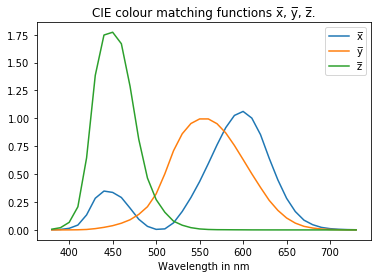

In [6]:
plt.plot(wavelen, xbar, label='x̅')
plt.plot(wavelen, ybar, label='y̅')
plt.plot(wavelen, zbar, label='z̅')
plt.title('CIE colour matching functions x̅, y̅, z̅.')
plt.legend()
plt.xlabel('Wavelength in nm')
plt.show()

### xyY to XYZ

In [7]:
def xyY2XYZ(x, y, Y):

    X = (x*Y) / y
    Y = Y
    Z = ((1.0 - x - y) * Y) / y
    
    return X, Y, Z

### Spectrum to XYZ

In [8]:
def spectrum2XYZ(xbar, ybar, zbar, color):
    k = 1.0 / np.sum(illuminance * ybar)
    
    X = k * np.sum(illuminance * xbar * color)
    Y = k * np.sum(illuminance * ybar * color)
    Z = k * np.sum(illuminance * zbar * color)
    
    return X, Y, Z

### sRGB Companding

In [9]:
def gamma_correction(v):
    if v <= 0.0031308:
        v = 12.92 * v
    else:
        v = 1.055 * pow(v, (1.0/2.4)) - 0.055

    return v

### XYZ to sRGB

In [10]:
def XYZ2sRGB(X, Y, Z):
    XYZ_T = np.matrix([X, Y, Z]).T
    
    #sRGB D65
    sRGB = np.matrix([
        [3.2404542, -1.5371385, -0.4985314,],
        [-0.9692660, 1.8760108, 0.0415560,],
        [0.0556434, -0.2040259, 1.0572252],
    ])

    M = sRGB.dot(XYZ_T)
    
    return np.squeeze(np.asarray(M))

### Colorchecker colors

In [11]:
color_names = list()
color_values = list()

for index, row in data_colorchecker.iterrows():
    x, y, z = spectrum2XYZ(xbar, ybar, zbar, row.values)
    rgb = XYZ2sRGB(x, y, z)
    rgb = np.array([gamma_correction(c) for c in rgb])
    rgb = np.clip(rgb, 0.0, 1.0) # clip values [0-1]
    rgb = rgb * 255
    rgb = np.array(rgb, dtype='uint8')
    
    color_names.append(index)
    color_values.append(rgb)

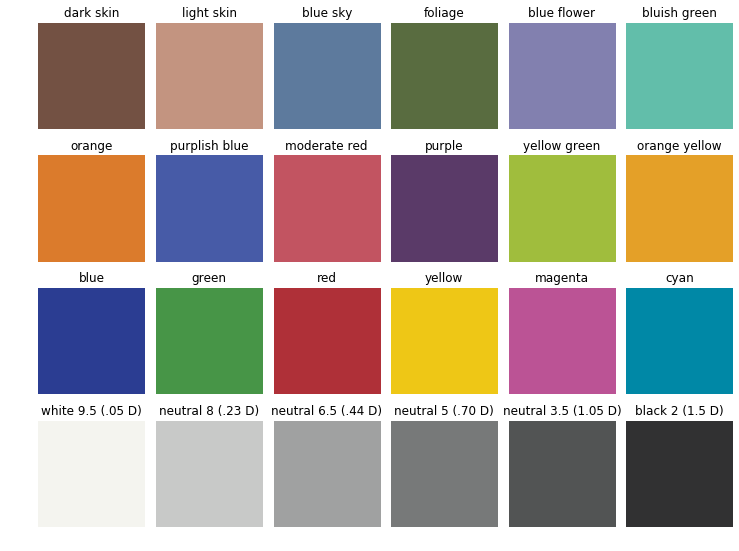

In [12]:
x, y = 4, 6 # size of color grid

fig, ax = plt.subplots(x, y, sharex='col', sharey='row', figsize=(14,14))

for i in range(x):
    for j in range(y):
        img_ij = np.full((2, 2, 3), color_values[i * y + j])
        
        ax[i, j].axis('off')
        ax[i, j].set_title(color_names[i * y + j])
        ax[i, j].imshow(img_ij)
        ax[i, j].set_aspect('equal')

fig.subplots_adjust(wspace=0.0, hspace=0.25, bottom=0.1, top=0.6, left=0.1, right=0.8)